In [5]:
import xml.etree.ElementTree as ET
import pandas as pd
from datetime import datetime

# XML dosyasını okuma
def read_xml_data(file_path):
    # XML dosyasını yükle
    tree = ET.parse(file_path)
    root = tree.getroot()

    # Verileri saklamak için liste
    step_records = []

    # Adım kayıtlarını XML'den çıkarma
    for record in root.findall(".//Record[@type='HKQuantityTypeIdentifierStepCount']"):
        start_date = datetime.strptime(record.get('startDate'), '%Y-%m-%d %H:%M:%S %z')
        steps = int(record.get('value', 0))

        # Her kaydı listeye ekle
        step_records.append({
            'date': start_date.date(),
            'steps': steps
        })

    # DataFrame oluşturma
    df = pd.DataFrame(step_records)
    return df

# Günlük toplam adım sayısını hesaplama
def calculate_daily_steps(df):
    daily_steps = df.groupby('date')['steps'].sum().reset_index()
    return daily_steps

# Veriyi okuma ve işleme
file_path = 'export.xml'  # XML dosya yolunu buraya yazın
df = read_xml_data(file_path)
daily_steps = calculate_daily_steps(df)

# İlk birkaç satırı görüntüleme
print(daily_steps.head())


         date  steps
0  2017-07-16   2532
1  2017-07-17   1858
2  2017-07-18   1000
3  2017-07-19   1353
4  2017-07-20    467


COVID-19
- T-Statistic: -40.965
- P-Value: 0.000
- Mean Period Steps (Normalized): -0.73
- Reference Mean Steps (Normalized): 0.11
- Significant: True
- Effect Direction: Lower

Final Exam Week 1
- T-Statistic: -7.990
- P-Value: 0.000
- Mean Period Steps (Normalized): -0.52
- Reference Mean Steps (Normalized): 0.01
- Significant: True
- Effect Direction: Lower

Final Exam Week 2
- T-Statistic: 5.615
- P-Value: 0.000
- Mean Period Steps (Normalized): 1.38
- Reference Mean Steps (Normalized): -0.01
- Significant: True
- Effect Direction: Higher

Final Exam Week 3
- T-Statistic: -2.906
- P-Value: 0.013
- Mean Period Steps (Normalized): -0.35
- Reference Mean Steps (Normalized): 0.00
- Significant: True
- Effect Direction: Lower

Final Exam Week 4
- T-Statistic: 0.111
- P-Value: 0.914
- Mean Period Steps (Normalized): 0.02
- Reference Mean Steps (Normalized): -0.00
- Significant: False
- Effect Direction: Higher

Final Exam Week 5
- T-Statistic: 1.831
- P-Value: 0.092
- Mean Period Steps (

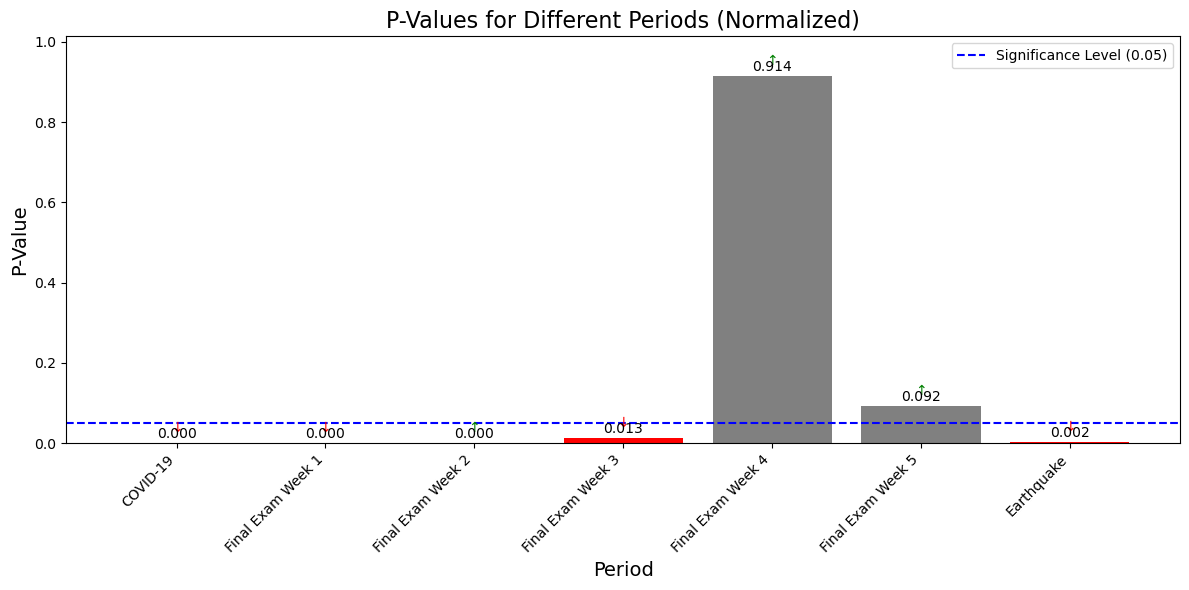

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime

class HypothesisTester:
    def __init__(self, daily_steps, periods):
        self.daily_steps = daily_steps.dropna(subset=['steps'])
        self.periods = periods
        
        # Normalize steps using Z-score
        self.daily_steps['steps_normalized'] = (
            self.daily_steps['steps'] - self.daily_steps['steps'].mean()
        ) / self.daily_steps['steps'].std()

    def test_periods(self):
        """Perform hypothesis testing for each period using normalized data"""
        results = []
        
        for period_name, period_range in self.periods.items():
            # Convert period start and end to datetime.date
            start_date = period_range['start'].date()
            end_date = period_range['end'].date()

            # Get period data
            period_mask = (
                (self.daily_steps['date'] >= start_date) & 
                (self.daily_steps['date'] <= end_date)
            )
            period_data = self.daily_steps[period_mask]['steps_normalized']
            
            # Get reference data (excluding the period being tested)
            reference_data = self.daily_steps[~period_mask]['steps_normalized']
            reference_mean = reference_data.mean()
            
            if not period_data.empty and not reference_data.empty:
                # Perform two-sided t-test
                t_stat, p_value = stats.ttest_1samp(period_data, reference_mean)
                
                results.append({
                    "Period": period_name,
                    "T-Statistic": t_stat,
                    "P-Value": p_value,
                    "Mean Period Steps (Normalized)": period_data.mean(),
                    "Reference Mean Steps (Normalized)": reference_mean,
                    "Significant": p_value < 0.05,
                    "Effect Direction": "Lower" if period_data.mean() < reference_mean else "Higher"
                })
        
        # Print results in the original format
        for result in results:
            print(f"{result['Period']}")
            print(f"- T-Statistic: {result['T-Statistic']:.3f}")
            print(f"- P-Value: {result['P-Value']:.3f}")
            print(f"- Mean Period Steps (Normalized): {result['Mean Period Steps (Normalized)']:.2f}")
            print(f"- Reference Mean Steps (Normalized): {result['Reference Mean Steps (Normalized)']:.2f}")
            print(f"- Significant: {result['Significant']}")
            print(f"- Effect Direction: {result['Effect Direction']}\n")
        
        return results

    def visualize_results(self, results):
        """Visualize the results as a bar plot"""
        periods = [result['Period'] for result in results]
        p_values = [result['P-Value'] for result in results]
        significance = [result['Significant'] for result in results]
        directions = [result['Effect Direction'] for result in results]

        plt.figure(figsize=(12, 6))
        bars = plt.bar(periods, p_values, 
                      color=['red' if sig else 'grey' for sig in significance])

        # Add direction indicators
        for idx, (bar, direction) in enumerate(zip(bars, directions)):
            color = 'green' if direction == 'Higher' else 'red'
            plt.text(idx, bar.get_height() + 0.02, 
                    f'↑' if direction == 'Higher' else '↓',
                    ha='center', va='bottom', color=color)

        plt.axhline(y=0.05, color='blue', linestyle='--', label='Significance Level (0.05)')

        # Annotate the bars with P-Values
        for bar, p_value in zip(bars, p_values):
            plt.text(bar.get_x() + bar.get_width() / 2, 
                    bar.get_height() + 0.005, 
                    f'{p_value:.3f}', 
                    ha='center', va='bottom')

        plt.title('P-Values for Different Periods (Normalized)', fontsize=16)
        plt.xlabel('Period', fontsize=14)
        plt.ylabel('P-Value', fontsize=14)
        plt.ylim(0, max(max(p_values) + 0.1, 0.5))
        plt.xticks(rotation=45, ha='right')
        plt.legend()
        plt.tight_layout()
        plt.show()

def main():
    # Define periods
    periods = {
        'COVID-19': {
            'start': datetime(2020, 3, 13),
            'end': datetime(2021, 3, 1)
        },
        'Final Exam Week 1': {
            'start': datetime(2022, 1, 2),
            'end': datetime(2022, 2, 14)
        },
        'Final Exam Week 2': {
            'start': datetime(2022, 6, 2),
            'end': datetime(2022, 6, 14)
        },
        'Final Exam Week 3': {
            'start': datetime(2023, 1, 2),
            'end': datetime(2023, 1, 14)
        },
        'Final Exam Week 4': {
            'start': datetime(2023, 6, 2),
            'end': datetime(2023, 6, 14)
        },
        'Final Exam Week 5': {
            'start': datetime(2024, 1, 2),
            'end': datetime(2024, 1, 14)
        },
        'Earthquake': {
            'start': datetime(2023, 2, 6),
            'end': datetime(2023, 2, 16)
        }
    }

    # Kullanıcı ayrı olarak günlük adım verilerini sağlamalıdır
    # Örnek: daily_steps = pd.read_csv('daily_steps.csv')

    # Initialize tester and run analysis
    tester = HypothesisTester(daily_steps, periods)
    results = tester.test_periods()
    tester.visualize_results(results)

if __name__ == "__main__":
    main()
